# Helpers

In [1]:
import numpy as np 
import scipy.sparse as sps
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import scipy 
import os
import datetime
import argparse
from IPython.display import clear_output

In [2]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import copy
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100 # default is 75
plt.style.use('default')
from tqdm import tqdm

In [3]:
carbon_inds = [3,6,9,13]
mask = torch.zeros(14, dtype=torch.bool)
for i in carbon_inds: 
    mask[i] = True

def compute_gram_matrix_recentered_torch(x):
    n_atoms = int(x.shape[0]/3)
    coords = x.reshape((n_atoms,3))
    coords = coords[[3,6,9,13],:]
    rescaled_coords = coords - torch.mean(coords,dim=0).reshape(1,3)
    gram = torch.matmul(rescaled_coords, rescaled_coords.T)
    return gram.flatten()

def compute_gram_matrix_recentered(x):
    assert x.shape[0]==12
    n_atoms = int(x.shape[0]/3)
    coords = x.reshape((n_atoms,3))
    rescaled_coords = coords - np.mean(coords,axis=0).reshape(1,3)
    gram = np.dot(rescaled_coords, rescaled_coords.T)
    return gram.flatten()

def recenter_bond_torch(x):
    x = x.reshape((4,3))
    recentered_x = x - x[1,:]
    theta = torch.sum(torch.atan2(recentered_x[...,1], recentered_x[...,0])*torch.Tensor([0,0,1,0]))
    M_xyT = torch.Tensor([[torch.cos(-theta), torch.sin(-theta), 0],[-torch.sin(-theta), torch.cos(-theta), 0], [0, 0, 1]])
    xy_rotated = torch.matmul(recentered_x, M_xyT)
    phi = torch.sum(torch.atan2(xy_rotated[...,2], xy_rotated[...,0])*torch.tensor([0,0,1,0]))
    M_zxT = torch.Tensor([[torch.cos(-phi),0, torch.sin(-phi)],[0, 1, 0], [-torch.sin(-phi), 0, torch.cos(-phi)]])
    zx_rotated = torch.matmul(xy_rotated, M_zxT)
    return zx_rotated.flatten()

def recenter_bond(x):
    x = x.reshape((4,3))
    assert x.shape == (4,3)
    recentered_x = x - x[1,:]
    theta = np.arctan2(recentered_x[2,1], recentered_x[2,0])
    xy_rotated = np.array([[np.cos(-theta), -np.sin(-theta), 0],[np.sin(-theta), np.cos(-theta), 0], [0, 0, 1]])@recentered_x.T
    xy_rotated = xy_rotated.T
    phi = np.arctan2(xy_rotated[2,2], xy_rotated[2,0])
    zx_rotated = np.array([[np.cos(-phi),0, -np.sin(-phi)],[0, 1, 0], [np.sin(-phi), 0, np.cos(-phi)]])@xy_rotated.T
    zx_rotated = zx_rotated.T
    return zx_rotated.flatten()

def recenter_bond_torch_with_mask(x):
    x = x.reshape((14,3))
    x = x[[3,6,9,13,],:]
    recentered_x = x - x[1,:]
    theta = torch.atan2(recentered_x[2,1], recentered_x[2,0])
    xy_rotated = torch.matmul(torch.Tensor([[torch.cos(-theta), -torch.sin(-theta), 0],[torch.sin(-theta), torch.cos(-theta), 0], [0, 0, 1]]),\
                              torch.transpose(recentered_x, 1, 0))
    xy_rotated = torch.transpose(xy_rotated,1,0)
    phi = torch.arctan2(xy_rotated[2,2], xy_rotated[2,0])
    zx_rotated = torch.matmul(torch.Tensor([[torch.cos(-phi),0, -torch.sin(-phi)],[0, 1, 0], [torch.sin(-phi), 0, torch.cos(-phi)]]), \
                              torch.transpose(xy_rotated,1,0))
    zx_rotated = torch.transpose(zx_rotated,1,0)
    return zx_rotated.flatten()

# Data

In [48]:
fname = "ground_data/butane_metad_nonaligned.npz" #butane_metad.npz DNMTBut.npz butane_hightemp.npz
inData = np.load(fname)
print("Keys in data:")
print(list(inData.keys()))

data_meta = inData["data"]
dataMetaD = data_meta
print("Data shape from trajectory:")
print(dataMetaD.shape)
dihedralsMetaD = inData["dihedrals"] # the one dim dihedral angles
potentialMetaD = inData["potential"] # potential related to the particular data point
print(potentialMetaD.shape)
print(dihedralsMetaD.shape)
kbT_roomtemp = inData["kbT_roomtemp"]

Keys in data:
['data', 'data_all_atom', 'dihedrals', 'potential', 'kbT', 'kbT_roomtemp', 'free_energy', 'biasFactor', 'biasWidth', 'height', 'frequency']
Data shape from trajectory:
(100000, 12)
(100000,)
(100000,)


## Visualize Dihedrals

In [49]:
data = dataMetaD[::10, :]
dihedrals = dihedralsMetaD[::10]
potentials = potentialMetaD[::10]
target_measure = np.exp(-potentials/(kbT_roomtemp))

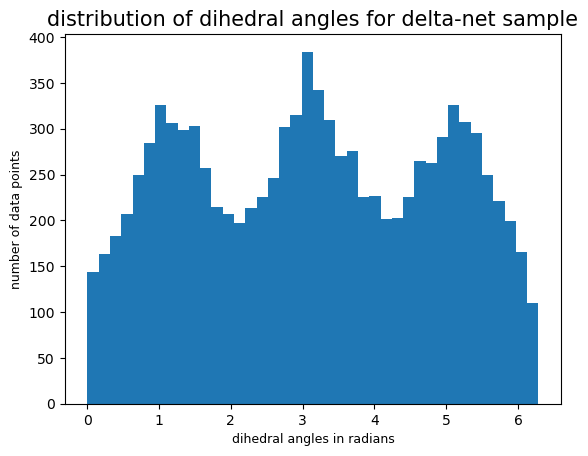

In [50]:
plt.hist(dihedrals, 40) 
plt.title("distribution of dihedral angles for delta-net sample", fontsize = 15)
plt.xlabel("dihedral angles in radians", fontsize = 9)
plt.ylabel("number of data points", fontsize = 9)
plt.savefig("dihedral_dist_metad.pdf")

## Load tmdmap

In [51]:
diff_data = np.load("tmdmap_carbons_recentered12_alphazero_sep29_2024.npz", allow_pickle=True)
# the relevant indices are 1, 2, 3. 

# comment out the following for jul 25 data. 
diffcoords = diff_data['diffcoords'][:,:4]
L = diff_data['L']
eigvals = diff_data['eigvals']
Ltorch = torch.Tensor(L)
eigvals_mat = torch.Tensor(eigvals)[:4,:4]

# diffcoords = np.load("tmdmap_carbons_recentered12_alphazero_jul25_2024.npz")
# diffcoords = diffcoords['arr_0']
# diffcoords = diff_data['arr_0']

In [52]:
size_vec = np.pi - np.abs(dihedrals - np.pi)
dihedrals_vec = np.abs(dihedrals - np.pi)

In [53]:
diffcoords.shape

(10000, 4)

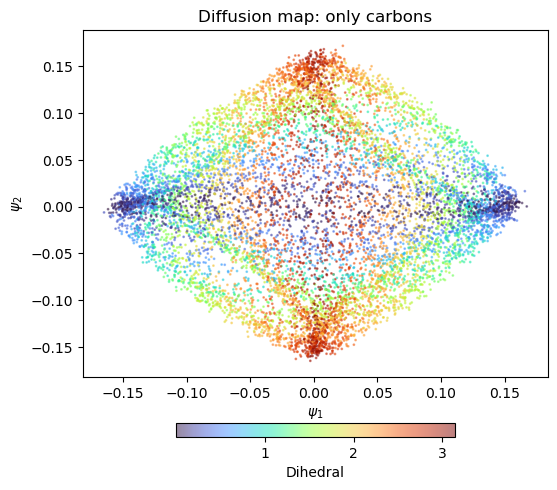

In [54]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
p = ax.scatter(diffcoords[:, 0], diffcoords[:, 2], \
               c=dihedrals_vec, cmap='turbo', s=1.0, alpha=0.5)
ax.set_xlabel(f"$\psi_1$")
ax.set_ylabel(f"$\psi_2$")
# ax.set_zlabel(f"$\psi_3$")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral')
# ax.view_init(elev=30, azim=-150)
ax.set_title("Diffusion map: only carbons")
plt.show()

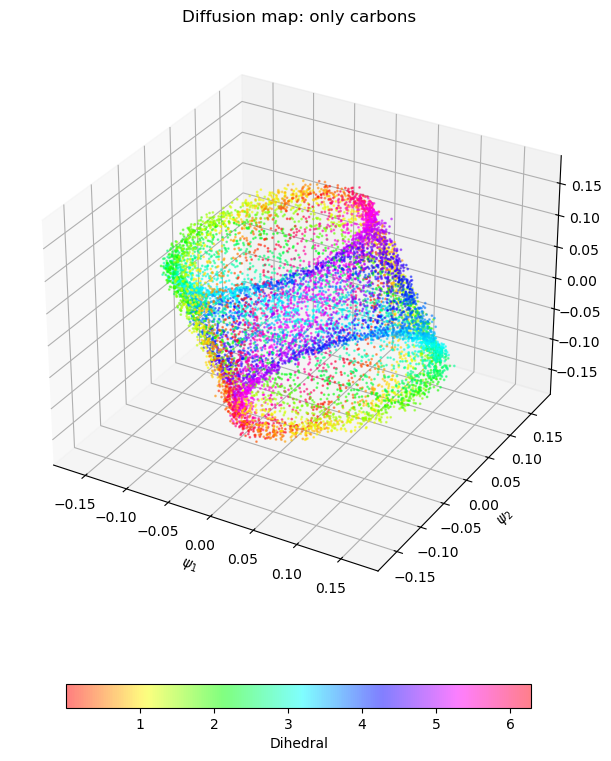

In [55]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(diffcoords[:, 0], diffcoords[:, 2], diffcoords[:,3], \
               c=dihedrals, cmap='hsv', s=1.0, alpha=0.5)
ax.set_xlabel(f"$\psi_1$")
ax.set_ylabel(f"$\psi_2$")
# ax.set_zlabel(f"$\psi_3$")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral')
# ax.view_init(elev=30, azim=-150)
ax.set_title("Diffusion map: only carbons")
plt.show()

# Learn Diffusion Net

## NN architectures

In [56]:
# setup featurizer
# feature_map = torch.vmap(compute_gram_matrix_recentered_torch)
layer = RecenterBondLayer(batch_mode=True)  # Enable batch mode
device = 'cpu'

In [57]:
class Encoder(nn.Module):
    def __init__(self, feature_map, activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim):
        super(Encoder, self).__init__()
        
        # Defining the layers of the neural network
        self.featurizer = feature_map
        self.activation = activation
        self.hidden1 = nn.Linear(input_dim, hidden1_dim)
        self.hidden2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.hidden3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.hidden4 = nn.Linear(hidden3_dim, hidden4_dim)
        self.bottleneck = nn.Linear(hidden4_dim, encoder_dim)

        # Collecting layers for convenience
        self.encoder = nn.Sequential(self.hidden1, self.activation, \
                                     self.hidden2, self.activation, \
                                        self.hidden3, self.activation, \
                                            self.hidden4, self.activation, \
                                                self.bottleneck, self.activation)

    
    def encode(self, x):
        y = self.featurizer(x)
        return self.encoder(y)
    
    # Required for any subclass of nn.module: defines how data passes through the `computational graph'
    def forward(self, x):
        # x = self.featurizer(x)
        return self.encode(x)

In [58]:
class Decoder(nn.Module):
    def __init__(self, activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim):
        super(Decoder, self).__init__()
        
        # Defining the layers of the neural network
        self.activation = activation
        self.hidden4 = nn.Linear(encoder_dim, hidden4_dim)
        self.hidden3 = nn.Linear(hidden4_dim, hidden3_dim)
        self.hidden2 = nn.Linear(hidden3_dim, hidden2_dim)
        self.hidden1 = nn.Linear(hidden2_dim, hidden1_dim)
        self.reconstruct = nn.Linear(hidden1_dim, input_dim)

        # Collecting layers for convenience as encoder and decoder
        self.decoder = nn.Sequential(self.hidden4, self.activation, self.hidden3, self.activation, self.hidden2, self.activation, self.hidden1, self.activation, self.reconstruct)

    
    def decode(self, z):
        return self.decoder(z)
        
    # Required for any subclass of nn.module: defines how data passes through the `computational graph'
    def forward(self, x):
        return self.decode(x)

In [59]:
# this defines the structure of the model

activation = nn.Tanh() 
input_dim = 12
hidden1_dim = 32
hidden2_dim = 32
hidden3_dim = 32
hidden4_dim = 32
encoder_dim = 4
output_dim = 12


# regular models:

# initializing the optimizer for the decoder
model_decoder_reg = Decoder(activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim).to(device)
optimizer_reg_dec = optim.Adam(model_decoder_reg.parameters(), lr=1e-4, weight_decay = 1e-5)

# initializing the optimizer for the encoder
model_encoder_reg = Encoder(layer, activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim).to(device)
optimizer_reg_enc = optim.Adam(model_encoder_reg.parameters(), lr = 1e-4, weight_decay=1e-5)


# lagged models:
# initializing the optimizer for the time-lagged encoder
model_encoder_lag = Encoder(layer, activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim).to(device)
optimizer_lag_enc = optim.Adam(model_encoder_lag.parameters(), lr=0.7e-5, weight_decay = 1e-5) 

# initializing the optimizer for the time-lagged decoder
model_decoder_lag = Decoder(activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim).to(device)
optimizer_lag_dec = optim.Adam(model_decoder_lag.parameters(), lr=0.7e-5,weight_decay = 1e-5) 

# the parameter values have been tuned to obtain convergence and an image resembling that of the tmdmap

loss_function = nn.MSELoss()

## Datasets

In [60]:
# set up output data
out = diffcoords[:,:4]
print(out.shape)
outtorch = torch.from_numpy(out).float().T # converted our output from diff map to torch
print(outtorch.shape)

# set up input data
train_data = torch.from_numpy(data).float() # converting the data to torch tensor
num_points = train_data.shape[0] 
# train_data = train_data_flat.reshape((num_points, 4, 3))
gram_matrices_train = layer(train_data).T
# train_data = data[:, :] 
# we could divide the data into two sets for training and testing.
# but, for the final implementation i decided to use all the tmdmap data for training (to improve accuracy), since it was established through testing that the network converged well.
print(train_data.shape)

(10000, 4)
torch.Size([4, 10000])
torch.Size([10000, 12])


In [61]:
layer(train_data[0,:].unsqueeze(0))

tensor([[-6.3206e-01, -7.3921e-01,  1.2062e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.5360e+00, -2.4389e-08, -1.8257e-08,  2.1154e+00,
          7.3944e-01, -1.2472e+00]])

In [62]:
np.random.seed(10)
torch.manual_seed(10)
# For defining operations on cuda if computer has it available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
dim = 4 # dimension of the output layer of the NN
train = True
# eigvals_mat = torch.diag(torch.Tensor(eigvals[:dim]))

Using cpu device


In [63]:
class MyDataset(torch.utils.data.Dataset):
    """Basic dataset container

    Parameters
    ----------
     data_tensor : (num_features, num_data) Tensor
         
    """    
    def __init__(self, data_tensor, diffmap_tensor, gram_matrices_tensor): # CHANGED 
        self.data_tensor = data_tensor
        self.diffmap_tensor = diffmap_tensor
        self.gram_matrices = gram_matrices_tensor
    def __getitem__(self, index):
        return index, self.data_tensor[index], self.diffmap_tensor[index], self.gram_matrices[index]
    def __len__(self):
        return self.data_tensor.size(0)

class LaggedDataset(torch.utils.data.Dataset): # An iterator that returns a tuple with (originalData, TimeLaggedOriginalData, TMDiffusionMapData) on each iteration
    """ Container for creating and utilizing time-lagged time-series

    Parameters
    ----------
        data_tensor : (num_features, num_data) Tensor
            time series dataset
        lag: integer
            number of frames for time-lag
    """    
    def __init__(self, data_tensor, diffmap_tensor, lag=1):
        assert data_tensor.size(0) > lag, 'you need more samples than lag'
        assert lag >= 0, 'you need a non-negative lagtime'
        self.data_tensor = data_tensor
        self.lag = lag
        self.diffmap_tensor = diffmap_tensor
    def __getitem__(self, index):
        return index, self.data_tensor[index], self.data_tensor[index + self.lag], self.diffmap_tensor[index]
    def __len__(self):
        return self.data_tensor.size(0) - self.lag

In [64]:
regular_data = MyDataset(train_data, outtorch.T[:, :4], gram_matrices_train.T)
train_loader = torch.utils.data.DataLoader(regular_data, batch_size=128, shuffle=True)

In [65]:
_, (_, raw_data, diff_map, features) = next(enumerate(train_loader))

## Training loop

In [69]:
def jj_transpose_loss(model,inputs):
    j_phi = torch.autograd.functional.jacobian(model, inputs)
    jj_prod = torch.einsum('ijkl,imkl -> ijkm', j_phi, j_phi)
    jj_prod_pruned = torch.diagonal(jj_prod, dim1=0, dim2=2)
    jj_minus_i = jj_prod_pruned-torch.eye(2).unsqueeze(2).repeat(1,1,inputs.shape[0])
    return loss_function(jj_minus_i, torch.zeros(jj_minus_i.shape))

In [70]:
mse_loss = torch.nn.MSELoss()

In [73]:
def train_sep(model_enc, model_dec, optimizer_enc, optimizer_dec, epoch, train_loader,verbose=False): # training for regular autoencoder
    model_enc.train()
    model_dec.train()
    loss1 = 0 # loss associated with the encoder
    loss2 = 0 
    loss3 = 0 
    loss4 = 0 # loss associated with the decoder
    
    # training loop
    for batch_idx, (indices, data, _, features) in enumerate(train_loader):
        data = data.to(device)
        # diff_map = diff_map.to(device)
        # features = features.to(device)
        data.requires_grad_(True)
        encoded_data = model_enc(data.float()) 
        decoded_data = model_dec(encoded_data)

        optimizer_enc.zero_grad() 
        optimizer_dec.zero_grad()
        
        # loss_tmd = loss_function(encoded_data, diff_map.float())
        jacobians = []
        for i in range(2):
            jj = torch.autograd.grad(encoded_data[:,i].sum(), data, create_graph=True)[0]
            jacobians.append(jj)
        inner_prods = torch.sum(jacobians[0]*jacobians[1], dim=1)
        loss_tmd = mse_loss(inner_prods, torch.zeros_like(inner_prods))

        loss_dec = loss_function(decoded_data, features.float())
        loss_eigs = torch.mean((torch.matmul(Ltorch[:,indices], encoded_data)[indices,...]-\
                     torch.matmul(encoded_data, eigvals_mat))**2)

        loss_enc = loss_tmd + 0.5*loss_eigs

        loss_total = loss_dec + loss_enc
        # loss_enc.backward(retain_graph=True)
        # loss_dec.backward()
        loss_total.backward(retain_graph = True)
        optimizer_enc.step()
        optimizer_dec.step()
        loss1 += loss_tmd.item()
        loss2 += loss_eigs.item()
        loss3 += loss_enc.item()
        loss4 += loss_dec.item()
    if verbose:
        print(f'====> Average loss: {loss1:.4f}, {loss2:.4f}, {loss3:.4f}')
        print('====> Average decoder loss: {:.4f}'.format(
            loss4 / len(train_loader.dataset)))
    # clear_output(wait=True)
def train_time_lagged_sep(model_enc, model_dec, optimizer_enc, optimizer_dec, epoch, train_loader): # training method for lagged-autoencoder
    model_enc.train()
    model_dec.train()
    loss1 = 0
    loss2 = 0
    
    # Note that we are grabbing pairs (data, data_lagged) for each iteration
    for batch_idx, (data, data_lagged, diff_map) in enumerate(train_loader):
        data = data.to(device)
        diff_map = diff_map.to(device)
        encoded_data = model_enc(data.float())
        decoded_data = model_dec(diff_map.float())
        data_lagged = data_lagged.to(device)

        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad() # ADDED CHECK IF THIS BREAKS THINGS TODO

        loss_enc = loss_function(encoded_data, diff_map.float())
        loss_dec = loss_function(decoded_data, data_lagged.float())
        loss_enc.backward()
        loss_dec.backward()

        optimizer_enc.step()
        optimizer_dec.step()
        loss1 += loss_enc.item()
        loss2 += loss_dec.item()

    print('====> Average loss: {:.4f}'.format(loss1 / len(train_loader.dataset)))
    print('====> Average loss: {:.4f}'.format(loss2 / len(train_loader.dataset)))
    clear_output(wait=True)
        #print(data_lagged.float().shape)
        #print(out.shape)

In [96]:
lag = 10 # defining the lag for the time-lagged autoencoder
batch_size = 64 
num_epochs = 500
train = True
if train:
    for epoch in tqdm(range(num_epochs)):
        # print(f"epoch {epoch}:")
        if epoch % 50 == 0:
            train_sep(model_encoder_reg, model_decoder_reg, optimizer_reg_enc, optimizer_reg_dec, epoch, train_loader, True)
        else: 
            train_sep(model_encoder_reg, model_decoder_reg, optimizer_reg_enc, optimizer_reg_dec, epoch, train_loader, False)

  0%|          | 1/500 [00:02<19:33,  2.35s/it]

====> Average loss: 0.0075, 0.0001, 0.0076
====> Average decoder loss: 0.0001


 10%|█         | 51/500 [01:57<17:17,  2.31s/it]

====> Average loss: 0.0987, 0.0001, 0.0988
====> Average decoder loss: 0.0001


 20%|██        | 101/500 [03:53<15:19,  2.30s/it]

====> Average loss: 0.0030, 0.0001, 0.0030
====> Average decoder loss: 0.0001


 30%|███       | 151/500 [05:49<13:25,  2.31s/it]

====> Average loss: 0.0125, 0.0001, 0.0126
====> Average decoder loss: 0.0000


 40%|████      | 201/500 [07:45<11:33,  2.32s/it]

====> Average loss: 0.0007, 0.0001, 0.0008
====> Average decoder loss: 0.0000


 41%|████      | 204/500 [07:53<11:27,  2.32s/it]


KeyboardInterrupt: 

# Test the diffusion net 

In [46]:
loader = False
if loader: 
    model_encoder_reg = Encoder(activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim).to(device)
    model_encoder_reg.load_state_dict(torch.load("model_encoder_DNet_Laplacian_26jul2024_carbons", map_location=device))
model_encoder_reg.eval()

Encoder(
  (activation): Tanh()
  (hidden1): Linear(in_features=12, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=32, bias=True)
  (hidden4): Linear(in_features=32, out_features=32, bias=True)
  (bottleneck): Linear(in_features=32, out_features=4, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=4, bias=True)
    (9): Tanh()
  )
)

In [97]:
# construct testing set 
num_points_test = dataMetaD.shape[0]
# test_data = torch.Tensor(dataMetaD.reshape((num_points_test, 4, 3)))
test_data = torch.Tensor(dataMetaD.reshape((num_points_test, 12)))
# gram_matrices_test = layer(test_data)
gram_matrices_test = test_data

In [98]:
encoded_out_nontl = model_encoder_reg(gram_matrices_train.T.float()).detach()
# encoded_out_test_nontl = model_encoder_reg(torch.from_numpy(gram_matrices_test).to(device).float()).detach() #test_data
encoded_out_test_nontl = model_encoder_reg(gram_matrices_test.to(device).float()).detach() #test_data
reconst_out_nontl = model_decoder_reg(encoded_out_nontl).T.detach()

In [99]:
encoded_out_nontl = encoded_out_nontl.cpu().numpy()
encoded_out_test_nontl = encoded_out_test_nontl.cpu().numpy()
# encoded_out_test_nontl = model_encoder_reg(torch.from_numpy(gram_matrices_test).to(device).float()).detach() #test_data
# reconst_out_nontl = model_decoder_reg(encoded_out_nontl).T.detach()

In [100]:
size_vec = np.pi - np.abs(dihedralsMetaD-np.pi)
dihedrals_vec = np.abs(dihedralsMetaD - np.pi)
test_indices = ~np.zeros(encoded_out_test_nontl.shape[0],dtype=bool)
test_indices[::10] = False

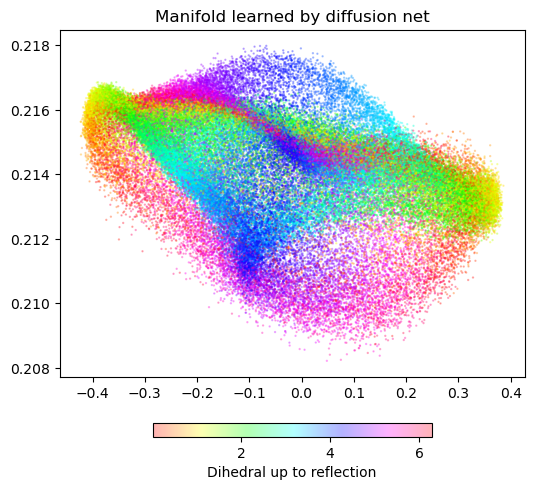

In [101]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
p = ax.scatter(encoded_out_test_nontl[test_indices, 0], encoded_out_test_nontl[test_indices, 1], \
               c=dihedralsMetaD[test_indices], cmap='hsv', s=0.5, alpha=0.3)
ax.set_title("Manifold learned by diffusion net")
# ax.view_init(elev=50, azim=120, roll=0)
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral up to reflection')

(10000, 4)


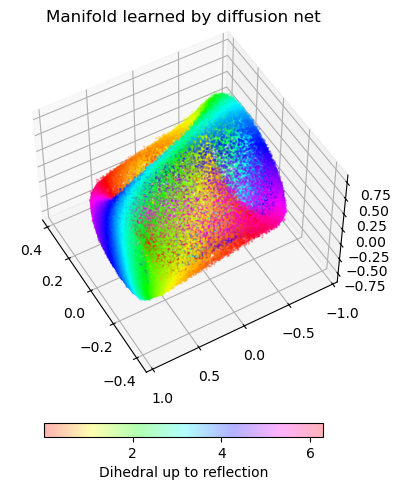

In [114]:
print(encoded_out_nontl.shape)
# reconst_out_nontl = reconst_out_nontl.numpy()
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(encoded_out_test_nontl[test_indices, 0], encoded_out_test_nontl[test_indices, 2], encoded_out_test_nontl[test_indices, 3],\
               c=dihedralsMetaD[test_indices], cmap='hsv', s=0.5, alpha=0.3)
ax.set_title("Manifold learned by diffusion net")
ax.view_init(elev=50, azim=150, roll=0)
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral up to reflection')

In [115]:
pointcloud = encoded_out_test_nontl[test_indices, :]
angles = dihedralsMetaD[test_indices]

In [116]:
np.savetxt("pointcloud_oct9.csv", pointcloud, delimiter=',')
np.savetxt("dihedrals_oct9.csv", angles, delimiter=',')

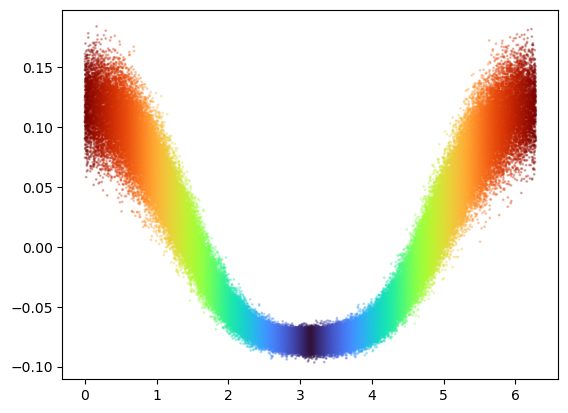

In [39]:
plt.scatter(dihedralsMetaD, r, c=dihedrals_vec,s=1.0, cmap='turbo', alpha=0.3)

(array([2951., 2778., 2800., 2690., 2538., 2534., 2331., 2251., 2137.,
        2063., 1937., 1810., 1776., 1731., 1657., 1542., 1605., 1535.,
        1592., 1733., 1781., 1829., 1845., 1994., 2049., 2203., 2259.,
        2416., 2417., 2538., 2571., 2555., 2455., 2455., 2410., 2337.,
        2200., 2146., 1996., 1881., 1768., 1676., 1588., 1410., 1339.,
        1289., 1277., 1194., 1075., 1056.]),
 array([2.65358979e-06, 6.28332536e-02, 1.25663854e-01, 1.88494454e-01,
        2.51325054e-01, 3.14155654e-01, 3.76986254e-01, 4.39816854e-01,
        5.02647454e-01, 5.65478054e-01, 6.28308654e-01, 6.91139254e-01,
        7.53969854e-01, 8.16800454e-01, 8.79631054e-01, 9.42461654e-01,
        1.00529225e+00, 1.06812285e+00, 1.13095345e+00, 1.19378405e+00,
        1.25661465e+00, 1.31944525e+00, 1.38227585e+00, 1.44510645e+00,
        1.50793705e+00, 1.57076765e+00, 1.63359825e+00, 1.69642885e+00,
        1.75925945e+00, 1.82209005e+00, 1.88492065e+00, 1.94775125e+00,
        2.01058185e+00, 

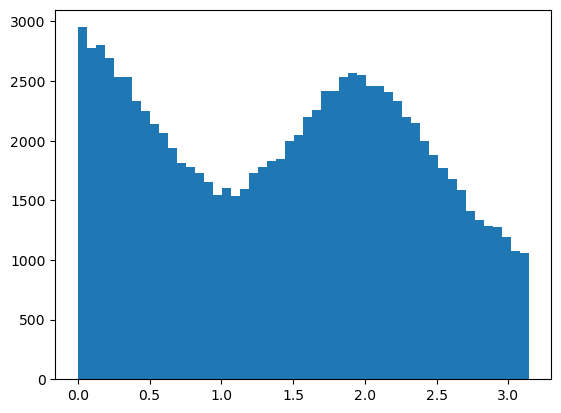

In [104]:
plt.hist(dihedrals_vec, bins=50)

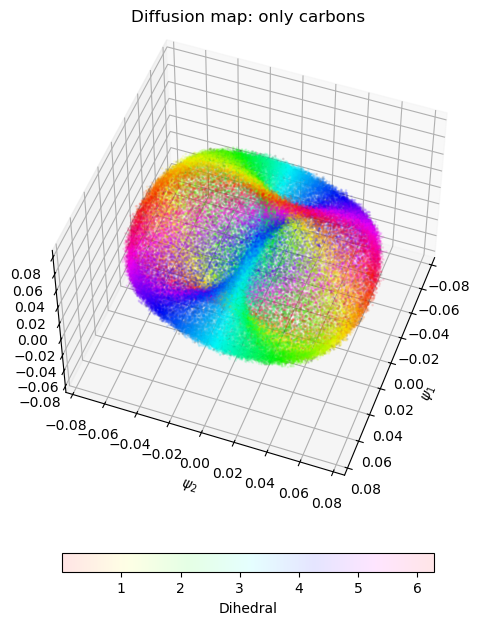

In [44]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(encoded_out_test_nontl[test_indices,0], encoded_out_test_nontl[test_indices, 1], encoded_out_test_nontl[test_indices,2], \
               c=dihedralsMetaD[test_indices], cmap='hsv', s=1.0, alpha=0.1)
p1 = ax.scatter(encoded_out_test_nontl[~test_indices,0], encoded_out_test_nontl[~test_indices, 1], encoded_out_test_nontl[~test_indices,2], \
               c='k', s=1.0, alpha=0.1)
ax.set_xlabel(f"$\psi_1$")
ax.set_ylabel(f"$\psi_2$")
# ax.set_zlabel(f"$\psi_3$")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral')
# ax.view_init(elev=30, azim=-150)
ax.set_title("Diffusion map: only carbons")
ax.view_init(azim=azim+80, elev=50, roll=roll)
plt.show()

In [73]:
# save neural network model

saver = True
if saver:
    torch.save(model_encoder_reg.state_dict(), "model_encoder_DNet_Laplacian_8oct2024_carbons")

# Fiddle with CV

In [40]:
class collective_variable(nn.Module):
    def __init__(self, featurizer, Dnet): 
        super().__init__()
        self.featurizer = featurizer
        self.Dnet = Dnet
    def forward(self,x):
        x = self.featurizer(x) 
        x = self.Dnet(x).flatten()
        return x[-1]

In [41]:
featurizer = RecenterBondLayer(batch_mode=False)
collective_var = collective_variable(featurizer, model_encoder_reg)

In [42]:
J = []
for i in tqdm(range(num_points_test)):
    j = torch.autograd.functional.jacobian(collective_var, test_data[i,:,:])
    J.append(torch.norm(j)**2)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [01:05<00:00, 1516.97it/s]


In [43]:
J = torch.Tensor(J).numpy()

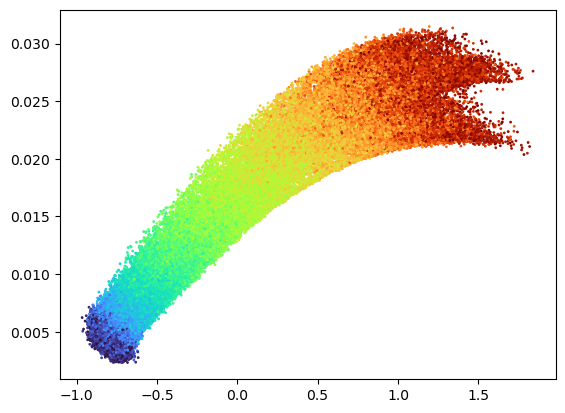

In [44]:
plt.scatter(10*r, J, c=dihedrals_vec, s=1.0, cmap='turbo')